# New case studies for Robot Dance paper

In [1]:
import os
import pandas as pd
import numpy as np
import datetime

import run_robot
import prepare_data
from importlib import reload
reload(prepare_data)
reload(run_robot)

Loading modules...
Loading modules... Ok!
Loading PyJulia module...
Loading PyJulia module... Ok!
Loading Robot-dance Julia module...
Loading Robot-dance Julia module... Ok!
Loading Julia library...
Loading Julia library... Ok!
Loading Robot-dance Julia module...
Loading Robot-dance Julia module... Ok!
Loading PyJulia module...
Loading PyJulia module... Ok!
Loading Robot-dance Julia module...
Loading Robot-dance Julia module... Ok!
Loading modules...
Loading modules... Ok!
Loading Julia library...
Loading Julia library... Ok!
Loading Robot-dance Julia module...
Loading Robot-dance Julia module... Ok!


<module 'run_robot' from '/home/pjssilva/documentos/pesquisa/robot_dance/code/run_robot.py'>

In [2]:
# Define the basic data for the case studies

# Compute initial values for first run and read the cities and other initial data
basic_prm = prepare_data.save_basic_parameters(min_level=0.8, rep=2.0, ndays=(180 + 28), tinf=2.9)

# Compute initial values and read mobility matrix

# For cities
# cities_data = prepare_data.compute_initial_condition_evolve_and_save(basic_prm, "SP", ["Araçatuba", "São José Do Rio Preto"], 500000, 1)
# cities_data = prepare_data.compute_initial_condition_evolve_and_save(basic_prm, "SP", ["São José Do Rio Preto"], 25000, 6, 1)
# M = prepare_data.convert_mobility_matrix_and_save(cities_data, max_neighbors=3, drs=False)

# For DRS
cities_data = prepare_data.compute_initial_condition_evolve_and_save(basic_prm, "SP", [], 1, 11, 1, "data/covid_with_drs.csv")
M = prepare_data.convert_mobility_matrix_and_save(cities_data, max_neighbors=3, drs=True)


1/22 Araraquara                     Mean effective R in the last two weeks = 1.11
2/22 Araçatuba                      Mean effective R in the last two weeks = 0.83
3/22 Baixada Santista               Mean effective R in the last two weeks = 1.12
4/22 Barretos                       Mean effective R in the last two weeks = 1.20
5/22 Bauru                          Mean effective R in the last two weeks = 0.98
6/22 Campinas                       Mean effective R in the last two weeks = 0.86
7/22 Franca                         Mean effective R in the last two weeks = 1.32
8/22 Marília                        Mean effective R in the last two weeks = 0.97
9/22 Mun. São Paulo                 Mean effective R in the last two weeks = 0.83
10/22 Piracicaba                     Mean effective R in the last two weeks = 0.81
11/22 Presidente Prudente            Mean effective R in the last two weeks = 1.04
12/22 Registro                       Mean effective R in the last two weeks = 0.84
13/22 Ribeir

In [3]:
cities_data = pd.read_csv("data/cities_data.csv", index_col=0)

# Create a target matrix (max infected level)
ncities, ndays = len(cities_data.index), int(basic_prm["ndays"])
target = np.ones((ncities, ndays))
target = prepare_data.save_target(cities_data, target)
hammer_data = prepare_data.save_hammer_data(cities_data, 0, 0.8)

# Use a forcedif that releases the cities in the end
force_dif = np.ones((ncities, ndays))
cities_data

,S1,E1,I1,R1,population,icu_capacity
Araraquara,0.899496,0.011714,0.006290,0.082500,991435.0,0.000153
Araçatuba,0.850827,0.013366,0.007951,0.127856,764041.0,0.000170
Baixada Santista,0.724331,0.019306,0.010291,0.246073,1831884.0,0.000267
Barretos,0.830193,0.021430,0.011145,0.137231,425090.0,0.000180
Bauru,0.861925,0.013815,0.007754,0.116506,1741281.0,0.000123
Campinas,0.809294,0.014708,0.008649,0.167349,4562125.0,0.000208
Franca,0.909556,0.014591,0.007352,0.068501,691672.0,0.000121
Marília,0.923380,0.007561,0.004256,0.064804,1109670.0,0.000154
Mun. São Paulo,0.781279,0.009444,0.005670,0.203607,11869660.0,0.000304
Piracicaba,0.811806,0.014601,0.008737,0.164856,1539600.0,0.000168


## Case 1: 14 day window, official data

In [14]:
verbosity = 2
basic_prm["alternate"] = 0.0
run_robot.find_feasible_hammer(basic_prm, cities_data, M, target, hammer_data, None, incr_all=True, save_file=False, verbosity=verbosity)
run_robot.prepare_optimization(basic_prm, cities_data, M, target, hammer_data, force_dif, verbosity=verbosity, test_budget=50000000)

Checking if initial hammer is long enough...
Time to simulate: 0.32
Araraquara is fine after 28 days of hammer (infected = 0.0001, target = 0.00011455365202963382)
Araçatuba is fine after 28 days of hammer (infected = 0.0001, target = 0.0001274735256354044)
Baixada Santista is fine after 28 days of hammer (infected = 9.2e-05, target = 0.00020008499446471503)
Barretos is fine after 28 days of hammer (infected = 0.00013, target = 0.00013534192759180413)
Bauru is fine after 42 days of hammer (infected = 5.6e-05, target = 9.19280116190322e-05)
Campinas is fine after 28 days of hammer (infected = 0.0001, target = 0.00015617722004548318)
Franca is fine after 42 days of hammer (infected = 7.3e-05, target = 9.062435376025368e-05)
Marília is fine after 28 days of hammer (infected = 7.5e-05, target = 0.00011518965097731757)
Mun. São Paulo is fine after 14 days of hammer (infected = 0.00016, target = 0.00022773230235743905)
Piracicaba is fine after 28 days of hammer (infected = 9.5e-05, target = 

Solving Robot-dance...
Solving Robot-dance... Ok!
Total tests used 4159152.8395409686

-----
Number of rt changes in each city
Araraquara: 14
Araçatuba: 13
Baixada Santista: 9
Barretos: 12
Bauru: 12
Campinas: 14
Franca: 13
Marília: 14
Mun. São Paulo: 10
Piracicaba: 13
Presidente Prudente: 12
Registro: 12
Ribeirão Preto: 12
Sorocaba: 14
Sub região leste - RMSP: 14
Sub região norte - RMSP: 12
Sub região oeste - RMSP: 13
Sub região sudeste - RMSP: 8
Sub região sudoeste - RMSP: 14
São José do Rio Preto: 9
São João da Boa Vista: 13
Taubaté: 13
-----

-----
Average fraction of infected
Araraquara: 0.0031449842290625194
Araçatuba: 0.0035766642807809135
Baixada Santista: 0.004912048568281267
Barretos: 0.004029608487481304
Bauru: 0.0025052025340759738
Campinas: 0.0046174023297821404
Franca: 0.002811391991688047
Marília: 0.002951938207492283
Mun. São Paulo: 0.005977670973794267
Piracicaba: 0.0036449943169902586
Presidente Prudente: 0.0019769809885081236
Registro: 0.003210034563091775
Ribeirão Pr

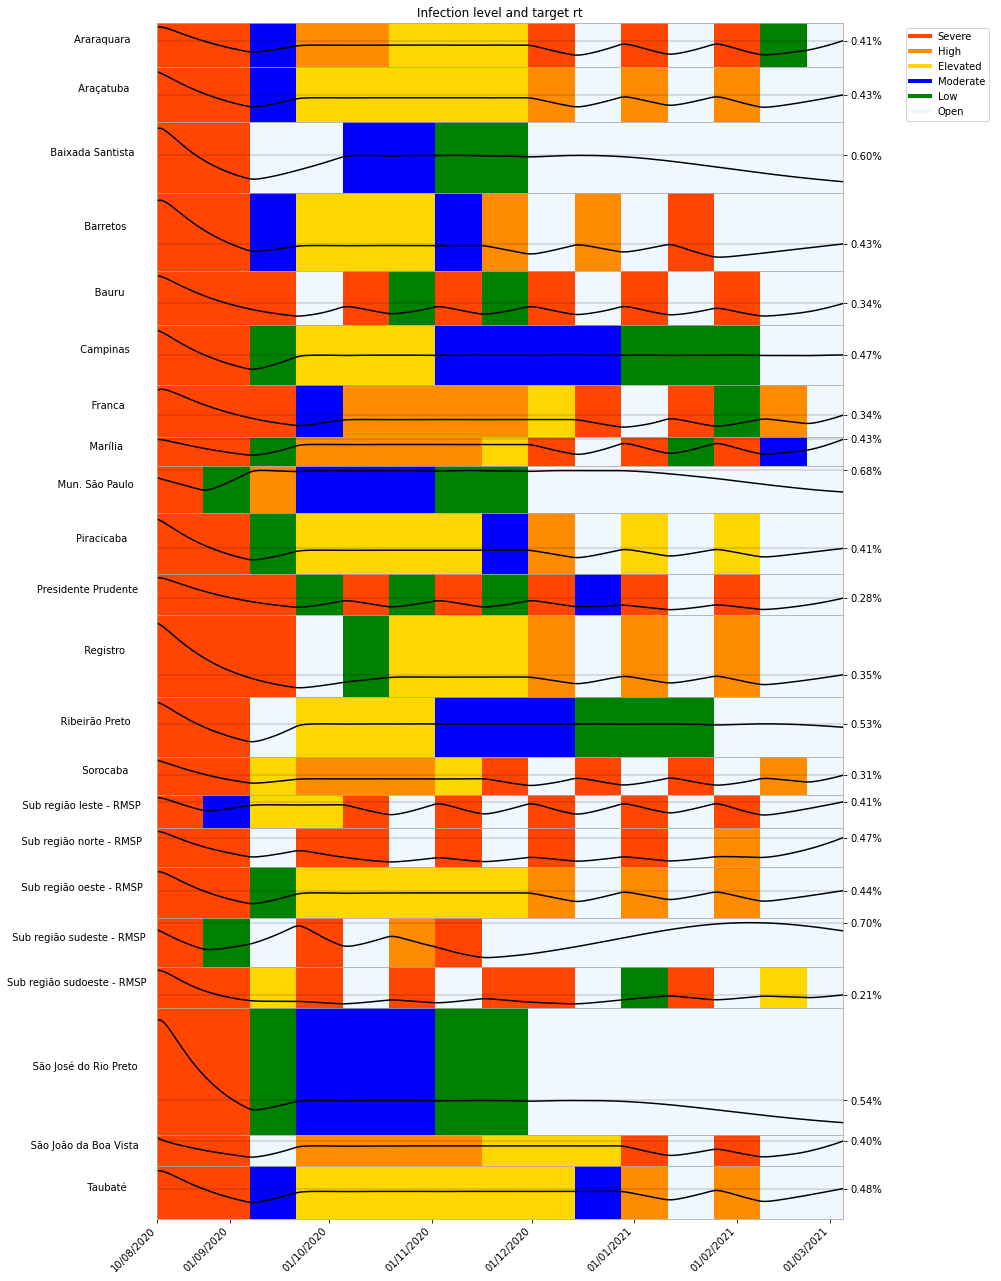

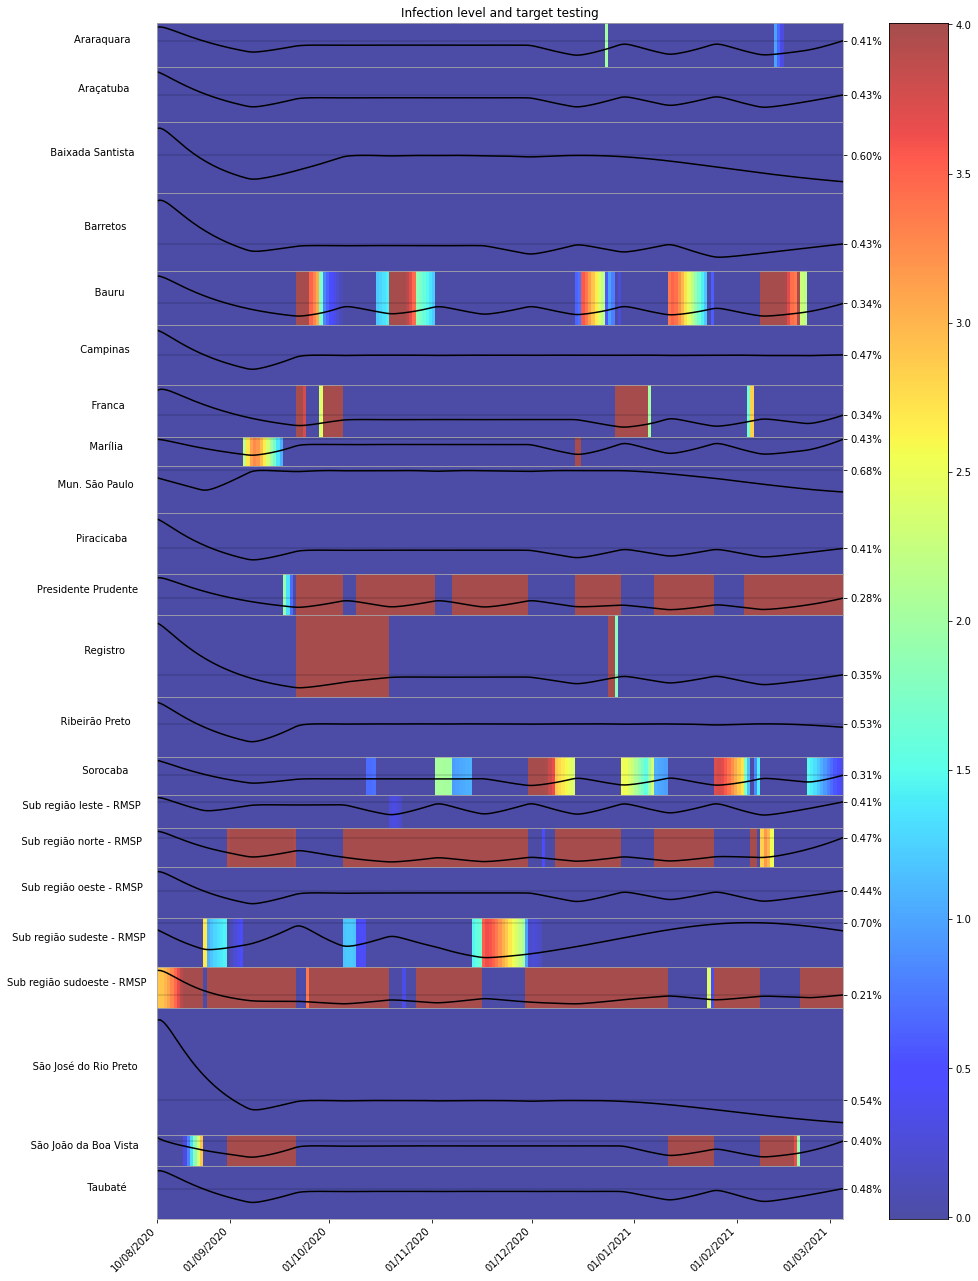

In [11]:
%%time
run_robot.optimize_and_show_results(basic_prm, "results/tests_new_50M_daily_unlimited_sp.png", "results/tests_new_50M_daily_unlimited_sp.csv", 
                                    cities_data, start_date="2020-08-10", verbosity=verbosity)